In [ ]:
!pip install -q -U keras-tuner
!pip install plot_keras_history

     |████████████████████████████████| 71kB 2.7MB/s 
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.29-cp37-none-any.whl size=8614 sha256=5c6ac6eda5565512ee78081ca68959c0eb4b63f118f565957fdd405e9ae9c0f0
  Stored in directory: /root/.cache/pip/wheels/8b/cb/fb/cbeba24d72e736b8987b7d0dc37afc0e76f3c16e544ceff727
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-cp37-none-any.whl size=7610 sha256=0c693103e307e4db7e452ed61d3739b7df32ea79390d21c42a7026cff681e38a
  Stored in directory: /root/.cache/pip/wheels/2a/62/31/d348320becc60729f508a2c5aad445b94d7543c5cb577cfb9d
  Created wheel for compress-json: filename=compress_json-1.0.4-cp37-none-any.whl size=4586 sha256=5b19d814ac9c214e0ba21bc8f38c8a148c0644e06bbab7a4257157405831364c
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import kerastuner as kt
import os
import os.path
import glob
from keras.utils.vis_utils import plot_model
from plot_keras_history import plot_history

# borderline-SMOTE for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from itertools import cycle
from scipy import interp

from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

pd.set_option('display.max_columns', 5)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_input_data():
  input_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ppmi/inputv4.csv')
  input_data = input_data.rename(columns={'APPRDX':'LABEL'})
  # quantile binning for age [continuous numerical data]
  quantile_list = [0, .25, .5, .75, 1.]
  quantiles = input_data['AGE'].quantile(quantile_list)
  quantile_labels = ['AGE_GROUP_1', 'AGE_GROUP_2', 'AGE_GROUP_3', 'AGE_GROUP_4']
  input_data.insert(3, 'AGE_GROUP', pd.qcut(input_data['AGE'], q=quantile_list, labels=quantile_labels))
  # dummy one-hot encoding for categorical data
  gen_onehot_features = pd.get_dummies(input_data['AGE_GROUP'])
  gen_dummy_features = gen_onehot_features.iloc[:,:-1]
  input_data.insert(4,'AGE_GROUP_1', gen_dummy_features['AGE_GROUP_1'])
  input_data.insert(5,'AGE_GROUP_2', gen_dummy_features['AGE_GROUP_2'])
  input_data.insert(6,'AGE_GROUP_3', gen_dummy_features['AGE_GROUP_3'])

  # write out the age quantile ranges for use when we deploy the model
  age_quantiles_df = pd.DataFrame(columns = ['AGE'])
  age_quantiles_df['AGE'] = quantiles
  age_quantiles_df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/ppmi/age_quantiles.csv', index = False)

  return input_data

In [ ]:
def one_hot_encode_stage(input):
  
  revised_data = input.copy()
  # dummy one-hot encoding for pd stage
  index = revised_data.columns.get_loc("STAGE")
  gen_dummy_features = pd.get_dummies(revised_data['STAGE'],drop_first=True)
  revised_data.insert(index,'STAGE_1', gen_dummy_features[1])
  revised_data.insert(index+1,'STAGE_2', gen_dummy_features[2])
  revised_data.insert(index+2,'STAGE_3', gen_dummy_features[3])  
  revised_data.insert(index+3,'STAGE_4', gen_dummy_features[4])  
  revised_data.insert(index+4,'STAGE_5', gen_dummy_features[5])

  return revised_data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def load_step1_data(step_input_data):
  if False: #(os.path.exists('/content/drive/MyDrive/Colab Notebooks/ppmi/step1_data.csv')):
    step1_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ppmi/step1_data.csv')
  else:
    step1_data = step_input_data.copy()
    step1_data = step1_data.drop(['PATNO','AGE', 'AGE_GROUP', 'STAGE', 'STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_4', 'STAGE_5'], axis = 1) 
    step1_data.drop(step1_data.iloc[:, step1_data.columns.get_loc("DRMVIVID"):], inplace = True, axis = 1)

  # create train, test data
  # train, test = np.split(step1_data.sample(frac=1, random_state=42), [int(.8*len(step1_data))])
  
  # train_columns = train.columns
  # train_data = train[train_columns[train_columns != 'LABEL']]
  # train_label = train['LABEL']
  
  # test_columns = test.columns
  # test_data = test[test_columns[test_columns != 'LABEL']]
  # test_label = test['LABEL']
  
  # train_data = train_data.values
  # train_label = train_label.values
  # test_data = test_data.values
  # test_label = test_label.values

  labels = step1_data.pop('LABEL')
  train_data, test_data, train_label, test_label = train_test_split(step1_data, labels)
  return step1_data, train_data, train_label, test_data, test_label

In [ ]:
def load_step2_data(step_input_data):

  if False: #(os.path.exists('/content/drive/MyDrive/Colab Notebooks/ppmi/step2_data.csv')):
    step2_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ppmi/step2_data.csv')
  else:
    step2_data = step_input_data.copy()
    step2_data = step2_data.drop(['PATNO','AGE', 'AGE_GROUP', 'LABEL', 'STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_4', 'STAGE_5'], axis = 1) 
    step2_data.drop(step2_data.iloc[:, step2_data.columns.get_loc("DRMVIVID"):], inplace = True, axis = 1)
    rna_path = '/content/drive/MyDrive/Colab Notebooks/ppmi/RNA-seq'
  
    # snca, gba, apoe, lrrk2
    gene_labels = ['SNCA', 'GBA', 'APOE', 'LRRK2', 'PRKN', 'PINK1']
    index = step2_data.columns.get_loc("STAGE")
    step2_data.insert(index, 'SNCA', 0.0)
    step2_data.insert(index+1, 'GBA', 0.0)
    step2_data.insert(index+2, 'APOE', 0.0)
    step2_data.insert(index+3, 'LRRK2', 0.0)
    step2_data.insert(index+4, 'PRKN', 0.0)
    step2_data.insert(index+5, 'PINK1', 0.0)
    pd_genes = ['ENSG00000145335', 'ENSG00000177628', 'ENSG00000130203', 'ENSG00000188906', 'ENSG00000185345', 'ENSG00000158828']

    for filename in glob.glob(os.path.join(rna_path, '*.sf')):
      basename = os.path.basename(filename)
      parts = basename.split('.')
      patno = parts[0]
      if (int(patno) in patients):
        patient_rna_data = pd.read_csv(filename, sep='\t')
        for ind in patient_rna_data.index: 
          gene = patient_rna_data['Name'][ind]
          tpm = patient_rna_data['TPM'][ind]
          if(tpm == ""):
            tpm = 0.0
          gene = gene.split('.')[0]
          if (gene in pd_genes):
            match_ind = pd_genes.index(gene)
            match_label = gene_labels[match_ind]
            step2_data.at[patients.index(int(patno)), match_label] = float(tpm)

    stage_data = step2_data[["STAGE"]]
    step2_data.drop(['STAGE'], inplace = True, axis = 1)
    gene_quantiles_df = pd.DataFrame(columns = gene_labels)
    print(gene_quantiles_df)

    for pd_gene in pd_genes: 
      # quantile binning for gene [continuous numerical data]
      quantile_list = [0, .25, .5, .75, 1.]
      match_ind = pd_genes.index(pd_gene)
      gene = gene_labels[match_ind]
      quantiles = step2_data[gene].quantile(quantile_list)
      gene_quantiles_df[gene] = quantiles
      quantile_labels = [gene+'_1', gene+'_2', gene+'_3', gene+'_4']
      step2_data[gene+'_GROUP'] = pd.qcut(step2_data[gene], q=quantile_list, labels=quantile_labels)
      # dummy one-hot encoding for categorical data
      gen_onehot_features = pd.get_dummies(step2_data[gene+'_GROUP'])
      gen_dummy_features = gen_onehot_features.iloc[:,:-1]
      step2_data[gene+'_1'] = gen_dummy_features[gene+'_1']
      step2_data[gene+'_2'] = gen_dummy_features[gene+'_2']
      step2_data[gene+'_3'] = gen_dummy_features[gene+'_3']
    
    # write out the gene TPM quantile ranges for use when we deploy the model
    print(gene_quantiles_df)
    gene_quantiles_df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/ppmi/gene_quantiles.csv', index = False)

    # drop unnecessary columns and add label column to end of df
    step2_data.drop(['SNCA_GROUP', 'GBA_GROUP', 'APOE_GROUP', 'LRRK2_GROUP', 'PRKN_GROUP', 'PINK1_GROUP'], inplace = True, axis = 1)
    step2_data.drop(gene_labels, inplace = True, axis = 1)
    step2_data = pd.concat([step2_data, stage_data], axis = 1)
    
  # creating instance of one-hot-encoder
  #enc = OneHotEncoder(handle_unknown='ignore')
  # passing bridge-types-cat column (label encoded values of bridge_types)
  #enc_df = pd.DataFrame(enc.fit_transform(step2_data[['STAGE']]).toarray())
  # merge with main df bridge_df on key values
  #step2_data = step2_data.join(enc_df)

  # create train, test data
  train, test = np.split(step2_data.sample(frac=1, random_state=42), [int(.8*len(step2_data))])
  train_columns = train.columns
  train_data = train[train_columns[train_columns != 'STAGE']]
  train_label = train['STAGE']
  
  test_columns = test.columns
  test_data = test[test_columns[test_columns != 'STAGE']]
  test_label = test['STAGE']

  train_label = pd.get_dummies(train_label)
  test_label = pd.get_dummies(test_label)

  #train_data = train_data.values
  #train_label = train_label.values
  #test_data = test_data.values
  #test_label = test_label.values

  return step2_data, train_data, train_label, test_data, test_label

In [ ]:
def load_step3_data(step_input_data):

  if(os.path.exists('/content/drive/MyDrive/Colab Notebooks/ppmi/step3_data.csv')):
    step3_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ppmi/step3_data.csv')
  else:
    step3_data = step_input_data.copy()
    label_data = step3_data[["STAGE"]]
    step3_data = step3_data.drop(['STAGE', 'STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_4', 'STAGE_5'], axis = 1)
    step3_data = pd.concat([step3_data, step3_additional_data, label_data], axis = 1)
  
  # creating instance of one-hot-encoder
  #enc = OneHotEncoder(handle_unknown='ignore')
  # passing bridge-types-cat column (label encoded values of bridge_types)
  #enc_df = pd.DataFrame(enc.fit_transform(step3_data[['STAGE']]).toarray())
  # merge with main df bridge_df on key values
  #step3_data = step3_data.join(enc_df)

  # create train, test data
  train, test = np.split(step3_data.sample(frac=1, random_state=42), [int(.8*len(step3_data))])
  train_columns = train.columns
  train_data = train[train_columns[train_columns != 'STAGE']]
  train_label = train['STAGE']
  
  test_columns = test.columns
  test_data = test[test_columns[test_columns != 'STAGE']]
  test_label = test['STAGE']

  train_label = pd.get_dummies(train_label)
  test_label = pd.get_dummies(test_label)

  #train_data = train_data.values
  #train_label = train_label.values
  #test_data = test_data.values
  #test_label = test_label.values

  return step3_data, train_data, train_label, test_data, test_label

In [ ]:
def build_step1_model(hp,shape):
  model = Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units, activation='relu', input_dim=shape[1]))
  
  # Add a dropout layer
  model.add(Dropout(rate=0.2))
  
  model.add(Dense(units=hp_units, activation='relu'))

  # Output layer is binary so only 1 neuron
  model.add(Dense(1, activation='sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

  return model

In [ ]:
def build_step2_model(hp,shape):
  model = Sequential()
  
  model.add(Flatten())

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units, activation='relu', input_shape=shape))
  
  # Add a dropout layer
  #model.add(Dropout(rate=0.5))
  
  model.add(Dense(units=hp_units, activation='relu'))
  model.add(Dense(units=hp_units, activation='relu'))
  model.add(Dense(units=hp_units, activation='relu'))

  # Output is PD stage 0-5, so 6 neurons
  model.add(Dense(6, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

  return model

In [ ]:
def build_step3_model(hp,shape):
  model = Sequential()
  
  model.add(Flatten())

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units, activation='relu', input_shape=shape))
  
  # Add a dropout layer
  #model.add(Dropout(rate=0.2))
  
  model.add(Dense(units=hp_units, activation='relu'))
  model.add(Dense(units=hp_units, activation='relu'))
  model.add(Dense(units=hp_units, activation='relu'))

  # Output is PD stage 0-5, so 6 neurons
  model.add(Dense(6, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

  return model

In [ ]:
def build_model1(hp):
  return build_step1_model(hp,step1_input_shape)

In [ ]:
def build_model2(hp):
  return build_step2_model(hp,step2_input_shape)

In [ ]:
def build_model3(hp):
  return build_step3_model(hp,step3_input_shape)

In [ ]:
def build_multiclass_model(dim):
  # create model
  model = Sequential()
  #model.add(Flatten())
  model.add(Dense(256, activation='relu', input_dim=dim))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(6, activation='softmax'))
  # Compile model
  opt = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
def run_multiclass_model(name,train,train_label,test,test_label):

  dim = len(train.columns)
  X = train.values.astype(float)
  Y = train_label.values
  testX = test.values.astype(float)
  testY = test_label.values

  # encode class values as integers
  encoder = LabelEncoder()
  encoder.fit(Y)
  encoded_Y = encoder.transform(Y)
  # convert integers to dummy variables (i.e. one hot encoded)
  dummy_y = np_utils.to_categorical(encoded_Y) 

  encoder.fit(testY)
  encoded_testY = encoder.transform(testY)
  dummy_testy = np_utils.to_categorical(encoded_testY)

  model = build_multiclass_model(dim)
  model.fit(X, dummy_y, epochs=100, verbose=2)
  
  # predict risks on test data and compare to actual risks
  scores = model.evaluate(testX, dummy_testy, verbose=1)
  
  # save the model
  #model.save('')
  
  # print accuracy results
  print(scores)
  print('Scores Accuracy: ' + str(scores[1]))

  # predict probabilities for test set
  y_predict_probs = model.predict(testX, verbose=0)
  # predict crisp classes for test set
  #y_predict_classes = model.predict_classes(testX, verbose=0)
  y_predict_classes = np.argmax(model.predict(testX), axis=-1)
  y_probs = y_predict_probs[:, 0]

  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(np.asarray(dummy_testy[:,1]), y_predict_classes)
  print('Accuracy: %f' % accuracy)

  return 

In [ ]:
def find_best_model(name, build_model_function, train_data, label_data):
  print(name + ': Tuning and Finding the Model with Best Hyperparameters')

  tuner = kt.Hyperband(build_model_function, objective='val_accuracy', max_epochs=20, factor=3, 
                     directory='/content/drive/MyDrive/Colab Notebooks/ppmi/model_logs', project_name='PDPredictor_'+name)
  stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  tuner.search(train_data, label_data, epochs=50, validation_split=0.2, callbacks=[stop_early])

  # Get the optimal hyperparameters
  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  print(f"""
  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
  is {best_hps.get('learning_rate')}.
  """)

  return tuner, best_hps

In [ ]:
def print_binary_metrics(model, test_data, test_label_data):

  y_pred_keras = model.predict(test_data).ravel()

  print("BINARY: TEST LABEL DATA")
  print(test_label_data)
  print("BINARY: Y SCORE")
  print(y_pred_keras)

  fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_label_data, y_pred_keras)
  auc_keras = auc(fpr_keras, tpr_keras)
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

  return

In [ ]:
def print_multiclass_metrics(model, test_data, test_label_data):

  # Plot linewidth.
  lw = 2

  # 6 classes to classify
  n_classes = 6
  
  y_score = model.predict_proba(test_data)

  print("TEST LABEL DATA")
  print(test_label_data)
  print("Y SCORE")
  print(y_score)

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(test_label_data.iloc[:, i], y_score[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  #fpr["micro"], tpr["micro"], _ = roc_curve(test_label_data.ravel(), y_score.ravel())
  #roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  #roc_auc = 

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(1)
  # plt.plot(fpr["micro"], tpr["micro"],
  #         label='micro-average ROC curve (area = {0:0.2f})'
  #               ''.format(roc_auc["micro"]),
  #         color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

  return

In [ ]:
def run_model(name, tuner, best_hps, train_data, train_label_data, test_data, test_label_data):
  
  print(name + ': Building the Model with Best Hyperparameters and Finding Best Epoch')

  # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
  model = tuner.hypermodel.build(best_hps)
  history = model.fit(train_data, train_label_data, epochs=50, validation_split=0.2)

  # plot training visualization
  plot_history(history.history, path='/content/drive/My Drive/Colab Notebooks/ppmi/'+name+'_history.png')
  
  val_acc_per_epoch = history.history['val_accuracy']
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
  print('Best epoch: %d' % (best_epoch,))
  
  hypermodel = tuner.hypermodel.build(best_hps)

  # Plot the best found model architecture
  plot_model(hypermodel, to_file='/content/drive/My Drive/Colab Notebooks/ppmi/'+name+'_plot.png', show_shapes=True, show_layer_names=True)

  print(name + ': Re-training the Model with Best Epoch')

  # Retrain the model
  hypermodel.fit(train_data, train_label_data, epochs=best_epoch)

  print(name + ': Evaluating the Model on Test Data')

  # Evaluate model on test data
  eval_result = hypermodel.evaluate(test_data, test_label_data)

  print("[Test Loss, Test Accuracy]:", eval_result)
  hypermodel.save('/content/drive/My Drive/Colab Notebooks/ppmi/'+name+'_model.h5')

  if name == 'Step1':
    print_binary_metrics(hypermodel, test_data, test_label_data)
  else:
    print_multiclass_metrics(hypermodel, test_data, test_label_data)

  return eval_result, best_epoch

In [ ]:
from sklearn import linear_model

input_data = load_input_data()
patients = input_data["PATNO"].tolist()
step3_additional_data = input_data.iloc[:,input_data.columns.get_loc("DRMVIVID"):] 

step1_data, step1_train, step1_label_train, step1_test, step1_label_test = load_step1_data(one_hot_encode_stage(input_data))

#step1_train.drop(labels=['STAGE_1'])

logreg = linear_model.LogisticRegression()
logreg.fit(step1_train, step1_label_train)
preds = logreg.predict(step1_test)

print(accuracy_score(step1_label_test, preds))
#preds

0.6470588235294118


In [ ]:
step1_train.columns[80:]

Index(['chr22:19963684:C:G_G_COMT_rs4818', 'chr22:19963748:G:A_A_COMT_rs4680',
       'chr22:19969258:G:A_G_COMT_rs165599'],
      dtype='object')

Empty DataFrame
Columns: [SNCA, GBA, APOE, LRRK2, PRKN, PINK1]
Index: []

[0 rows x 6 columns]
          SNCA      GBA  ...      PRKN     PINK1
0.00    0.0000   0.0000  ...   0.00000    0.0000
0.25   20.5619  15.3339  ...   4.40070   82.2332
0.50   27.9240  18.6572  ...   6.14611   93.3313
0.75   38.5391  22.2792  ...   8.15730  104.6720
1.00  193.4970  74.8698  ...  32.07720  475.4330

[5 rows x 6 columns]
Step1: Tuning and Finding the Model with Best Hyperparameters
INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Colab Notebooks/ppmi/model_logs/PDPredictor_Step1/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/ppmi/model_logs/PDPredictor_Step1/tuner0.json
INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is 288 and the optimal learning rate for the optimizer
  is 0.01.
  
Step1: Building the Model with Best Hyperparamete

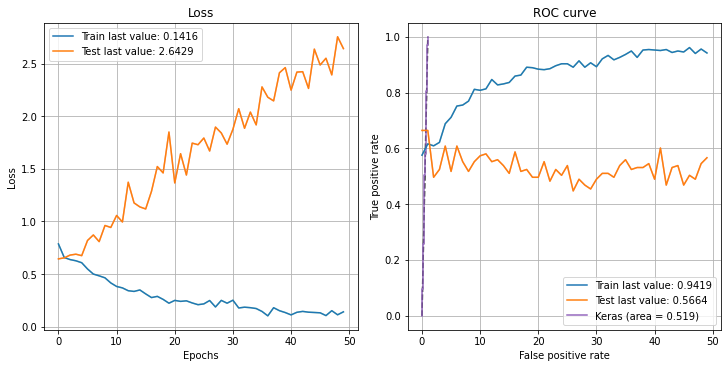

Step2: Tuning and Finding the Model with Best Hyperparameters
INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Colab Notebooks/ppmi/model_logs/PDPredictor_Step2/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/ppmi/model_logs/PDPredictor_Step2/tuner0.json
INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is 96 and the optimal learning rate for the optimizer
  is 0.01.
  
Step2: Building the Model with Best Hyperparameters and Finding Best Epoch
Epoch 1/50
19/19 [==============================] - 1s 18ms/step - loss: 1.4656 - accuracy: 0.3605 - val_loss: 1.4002 - val_accuracy: 0.4013
Epoch 2/50
19/19 [==============================] - 0s 7ms/step - loss: 1.3176 - accuracy: 0.4446 - val_loss: 1.3993 - val_accuracy: 0.3882
Epoch 3/50
19/19 [==============================] - 0s 9ms/step - loss: 1.1674 - accuracy: 0.5044 - val_l

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


TEST LABEL DATA
     0  1  ...  4  5
803  0  0  ...  0  0
556  0  1  ...  0  0
907  1  0  ...  0  0
577  0  0  ...  0  0
85   0  0  ...  0  0
..  .. ..  ... .. ..
106  0  0  ...  0  0
270  0  0  ...  0  0
860  0  0  ...  0  0
435  0  1  ...  0  0
102  1  0  ...  0  0

[190 rows x 6 columns]
Y SCORE
[[2.8783429e-01 4.4868324e-02 6.0526115e-01 6.0421009e-02 8.5278484e-04
  7.6250633e-04]
 [2.2633979e-01 3.0188795e-02 6.9727445e-01 4.5532189e-02 3.2662586e-04
  3.3819591e-04]
 [6.6590893e-01 1.5468862e-02 3.0389315e-01 1.4700940e-02 2.3576695e-05
  4.5143647e-06]
 ...
 [5.5433667e-01 1.5432285e-01 1.8735109e-01 9.0124212e-02 8.8998089e-03
  4.9653538e-03]
 [2.5597891e-01 3.7349831e-02 6.4839625e-01 5.6987673e-02 6.5131742e-04
  6.3610706e-04]
 [3.5227764e-01 1.1223656e-01 3.8840064e-01 1.2735012e-01 1.1356143e-02
  8.3788009e-03]]


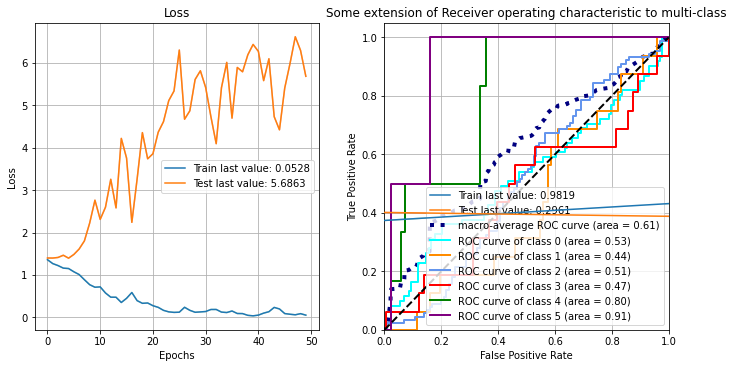

Step3: Tuning and Finding the Model with Best Hyperparameters
INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Colab Notebooks/ppmi/model_logs/PDPredictor_Step3/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/ppmi/model_logs/PDPredictor_Step3/tuner0.json
INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is 160 and the optimal learning rate for the optimizer
  is 0.01.
  
Step3: Building the Model with Best Hyperparameters and Finding Best Epoch
Epoch 1/50
19/19 [==============================] - 1s 22ms/step - loss: 1.6267 - accuracy: 0.4251 - val_loss: 1.0952 - val_accuracy: 0.6382
Epoch 2/50
19/19 [==============================] - 0s 7ms/step - loss: 0.9309 - accuracy: 0.6616 - val_loss: 0.6683 - val_accuracy: 0.7368
Epoch 3/50
19/19 [==============================] - 0s 8ms/step - loss: 0.5173 - accuracy: 0.8167 - val_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


TEST LABEL DATA
     0  1  ...  4  5
803  0  0  ...  0  0
556  0  1  ...  0  0
907  1  0  ...  0  0
577  0  0  ...  0  0
85   0  0  ...  0  0
..  .. ..  ... .. ..
106  0  0  ...  0  0
270  0  0  ...  0  0
860  0  0  ...  0  0
435  0  1  ...  0  0
102  1  0  ...  0  0

[190 rows x 6 columns]
Y SCORE
[[4.8190901e-17 7.9453306e-26 1.0000000e+00 7.3292188e-19 3.7229215e-26
  1.1098541e-16]
 [5.4136312e-05 9.9994433e-01 8.6005790e-13 6.7338647e-07 7.8834069e-07
  1.1454350e-10]
 [1.0000000e+00 2.3701887e-13 5.6820743e-11 1.2112657e-11 1.2226987e-13
  5.1511059e-08]
 ...
 [4.5411802e-08 1.4648998e-04 5.3405527e-11 9.9983954e-01 8.2455135e-06
  5.6745325e-06]
 [1.4675855e-07 9.9999988e-01 5.2734424e-19 1.4377065e-10 2.0044320e-10
  3.5522913e-16]
 [9.9997675e-01 5.0995932e-09 1.7961621e-07 7.4342182e-08 6.0311560e-09
  2.2875585e-05]]


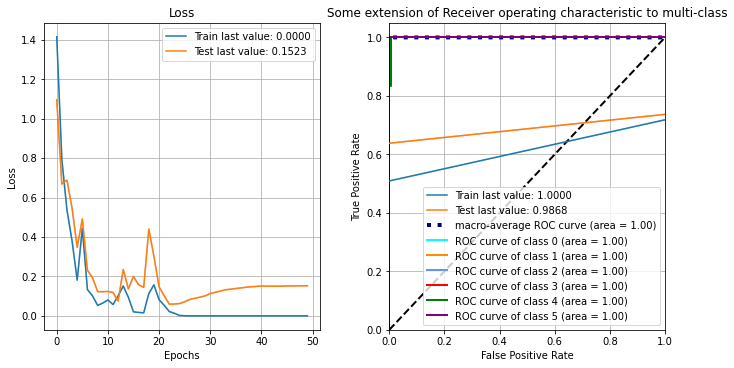


  Summary Results:

  Step1_model.h5
  # Neurons: 288
  Optimizer Learning Rate: 0.01
  Best Epoch: 1
  Test Loss, Test Accuracy: [0.6696321368217468, 0.6890756487846375]

  Step2_model.h5
  # Neurons: 96
  Optimizer Learning Rate: 0.01
  Best Epoch: 5
  Test Loss, Test Accuracy: [1.3891884088516235, 0.4368421137332916]

  Step3_model.h5
  # Neurons: 160
  Optimizer Learning Rate: 0.01
  Best Epoch: 23
  Test Loss, Test Accuracy: [0.059091709554195404, 0.9789473414421082]
  


In [ ]:
input_data = load_input_data()
patients = input_data["PATNO"].tolist()
step3_additional_data = input_data.iloc[:,input_data.columns.get_loc("DRMVIVID"):] 

step1_data, step1_train, step1_label_train, step1_test, step1_label_test = load_step1_data(one_hot_encode_stage(input_data))
#print(step1_data)
step1_data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/ppmi/step1_data.csv', index = False)

step2_data, step2_train, step2_label_train, step2_test, step2_label_test = load_step2_data(one_hot_encode_stage(input_data))
#print(step2_data)
step2_data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/ppmi/step2_data.csv', index = False)

step3_data, step3_train, step3_label_train, step3_test, step3_label_test = load_step3_data(step2_data)
#print(step3_data)
step3_data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/ppmi/step3_data.csv', index = False)

# build model for each of the steps and setup tuner to tune the model to best hyperparameters
step1_input_shape = step1_train.shape
tuner1, best_hps1 = find_best_model('Step1', build_model1, step1_train, step1_label_train)
eval_result1, best_epoch1 = run_model('Step1', tuner1, best_hps1, step1_train, step1_label_train, step1_test, step1_label_test)

step2_input_shape = step2_train.shape
tuner2, best_hps2 = find_best_model('Step2', build_model2, step2_train, step2_label_train)
eval_result2, best_epoch2 = run_model('Step2', tuner2, best_hps2, step2_train, step2_label_train, step2_test, step2_label_test)
#run_multiclass_model('Step2',step2_train,step2_label_train,step2_test,step2_label_test)

step3_input_shape = step3_train.shape
tuner3, best_hps3 = find_best_model('Step3', build_model3, step3_train, step3_label_train)
eval_result3, best_epoch3 = run_model('Step3', tuner3, best_hps3, step3_train, step3_label_train, step3_test, step3_label_test)

print(f"""
  Summary Results:

  Step1_model.h5
  # Neurons: {best_hps1.get('units')}
  Optimizer Learning Rate: {best_hps1.get('learning_rate')}
  Best Epoch: {best_epoch1}
  Test Loss, Test Accuracy: {eval_result1}

  Step2_model.h5
  # Neurons: {best_hps2.get('units')}
  Optimizer Learning Rate: {best_hps2.get('learning_rate')}
  Best Epoch: {best_epoch2}
  Test Loss, Test Accuracy: {eval_result2}

  Step3_model.h5
  # Neurons: {best_hps3.get('units')}
  Optimizer Learning Rate: {best_hps3.get('learning_rate')}
  Best Epoch: {best_epoch3}
  Test Loss, Test Accuracy: {eval_result3}
  """)
